In [0]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torchvision import models
from torchvision import transforms as tf
import torch.nn.functional as F

In [0]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
  param.requires_grad_(False)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [0]:
def transformation(img):

  tasks = tf.Compose([
    tf.Resize(256),
    tf.ToTensor(),
    tf.Normalize(mean, std)])
  
  img = tasks(img)
  img = img.unsqueeze(0)

  return img

In [0]:
img_dir = 'drive/My Drive/Colab Notebooks/data/style-transfer/'

content_img = Image.open(img_dir + 'cat2.jpg').convert('RGB')
style_img = Image.open(img_dir + 'cubism.jpg').convert('RGB')

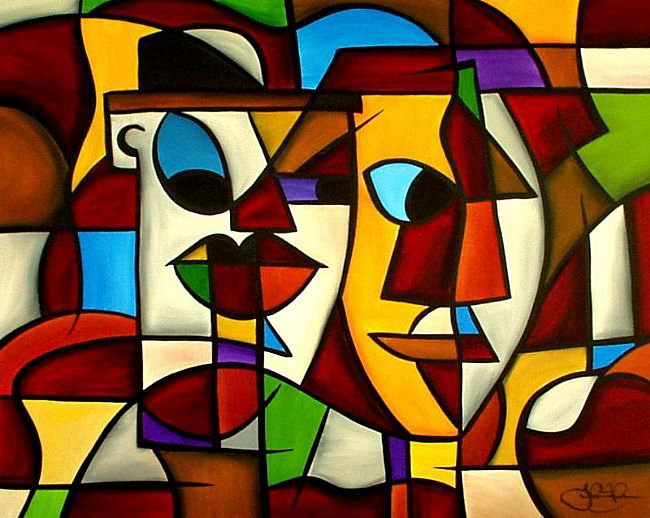

In [7]:
style_img

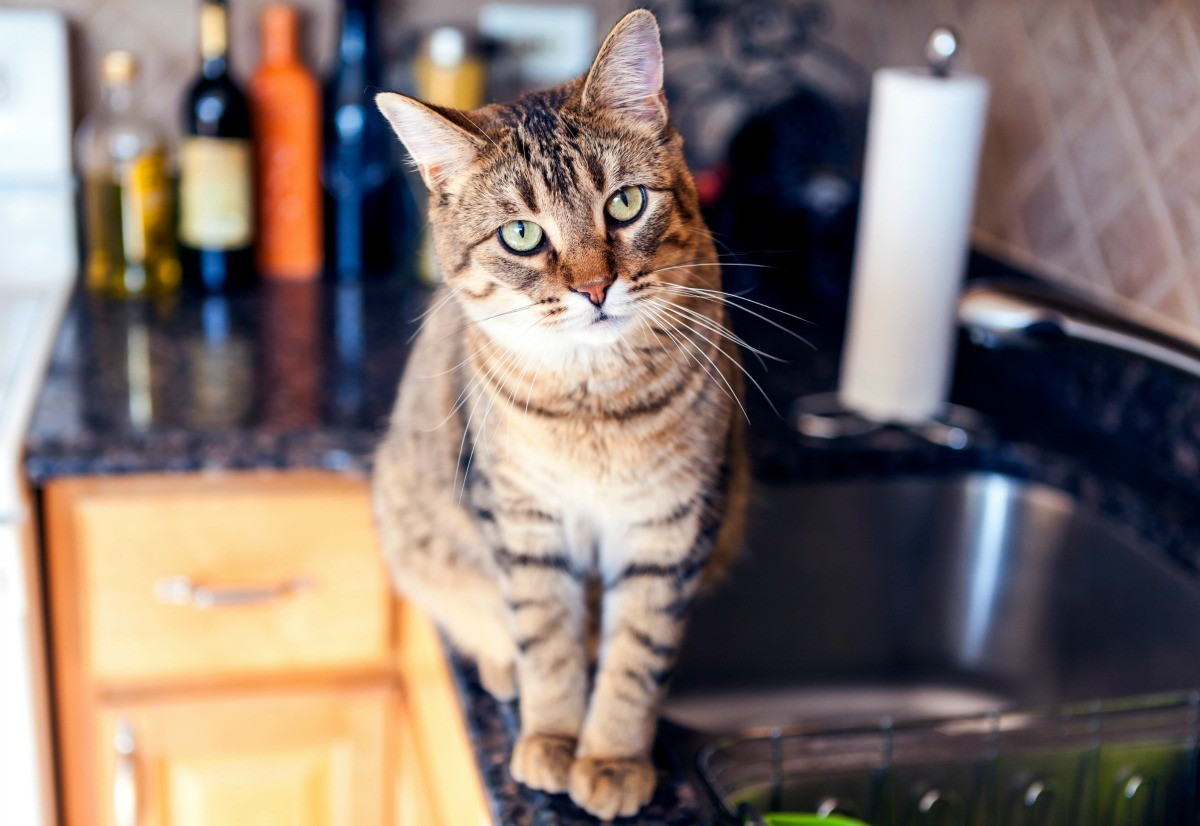

In [8]:
content_img

In [0]:
content_img = transformation(content_img).to(device)
style_img = transformation(style_img).to(device)

In [10]:
content_img.shape, style_img.shape

(torch.Size([1, 3, 256, 371]), torch.Size([1, 3, 256, 321]))

In [0]:
def tensor_to_image(tensor):

  image = tensor.clone().detach()
  image = image.cpu().numpy().squeeze()

  image = image.transpose(1, 2, 0)

  image *= np.array(std) + np.array(mean)
  image = image.clip(0, 1)

  return image

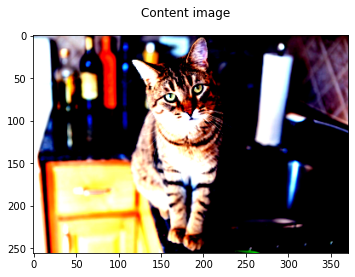

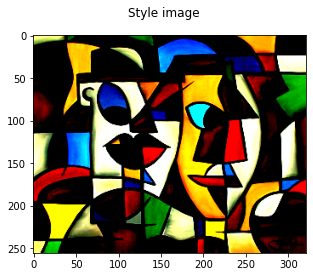

In [12]:
img = tensor_to_image(content_img)
fig = plt.figure()
fig.suptitle('Content image')
plt.imshow(img)

img = tensor_to_image(style_img)
fig = plt.figure()
fig.suptitle('Style image')
plt.imshow(img)

In [0]:
LAYERS_OF_INTEREST = {'0': 'conv1_1',
                       '5': 'conv2_1',
                       '10': 'conv3_1',
                       '19': 'conv4_1',
                       '21': 'conv4_2',
                       '28': 'conv5_1'}

In [0]:
def apply_model_and_extract_features(image, model):

  x = image
  features = {}

  for name, layer in model._modules.items():
    x = layer(x)

    if name in LAYERS_OF_INTEREST:
      features[LAYERS_OF_INTEREST[name]] = x
  
  return features

In [0]:
content_img_features = apply_model_and_extract_features(content_img, vgg)
style_img_features = apply_model_and_extract_features(style_img, vgg)

In [0]:
def calculate_gram_matrix(tensor):

  _, channels, height, width = tensor.size()
  tensor = tensor.view(channels, height * width)

  gram_matrix = torch.mm(tensor, tensor.t())
  gram_matrix = gram_matrix.div(channels * height * width)

  return gram_matrix

In [0]:
style_features_gram_matrix = {layer: calculate_gram_matrix(style_img_features[layer]) for layer in style_img_features}

In [0]:
weights = {'conv1_1': 1.0, 'conv2_1': 0.75, 'conv3_1': 0.35,
           'conv4_1': 0.25, 'conv5_1': 0.15}

In [0]:
target = content_img.clone().requires_grad_(True).to(device)

optimizer = optim.Adam([target], lr=0.003)

In [20]:
for i in range(1, 2000):

  target_features = apply_model_and_extract_features(target, vgg)

  content_loss = F.mse_loss(target_features['conv4_2'], content_img_features['conv4_2'])
  style_loss = 0

  for layer in weights:

    target_feature = target_features[layer]

    target_gram_matrix = calculate_gram_matrix(target_feature)
    style_gram_matrix = style_features_gram_matrix[layer]

    layer_loss = F.mse_loss(target_gram_matrix, style_gram_matrix)
    layer_loss *= weights[layer]

    _, channels, height, width = target_feature.shape

    style_loss += layer_loss

  total_loss = 1000000 * style_loss + content_loss

  if i % 50 == 0:
    print('Epoch: {}, Style loss: {:4f}, Content loss: {:4f}'.format(i, style_loss, content_loss))
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

Epoch: 50, Style loss: 0.000244, Content loss: 11.295175
Epoch: 100, Style loss: 0.000143, Content loss: 12.933299
Epoch: 150, Style loss: 0.000100, Content loss: 13.651163
Epoch: 200, Style loss: 0.000078, Content loss: 13.966843
Epoch: 250, Style loss: 0.000065, Content loss: 14.084895
Epoch: 300, Style loss: 0.000057, Content loss: 14.085489
Epoch: 350, Style loss: 0.000050, Content loss: 14.034040
Epoch: 400, Style loss: 0.000045, Content loss: 13.960402
Epoch: 450, Style loss: 0.000041, Content loss: 13.872524
Epoch: 500, Style loss: 0.000038, Content loss: 13.776577
Epoch: 550, Style loss: 0.000035, Content loss: 13.699916
Epoch: 600, Style loss: 0.000033, Content loss: 13.619625
Epoch: 650, Style loss: 0.000031, Content loss: 13.529219
Epoch: 700, Style loss: 0.000029, Content loss: 13.442012
Epoch: 750, Style loss: 0.000028, Content loss: 13.359480
Epoch: 800, Style loss: 0.000026, Content loss: 13.274691
Epoch: 850, Style loss: 0.000025, Content loss: 13.195777
Epoch: 900, Sty

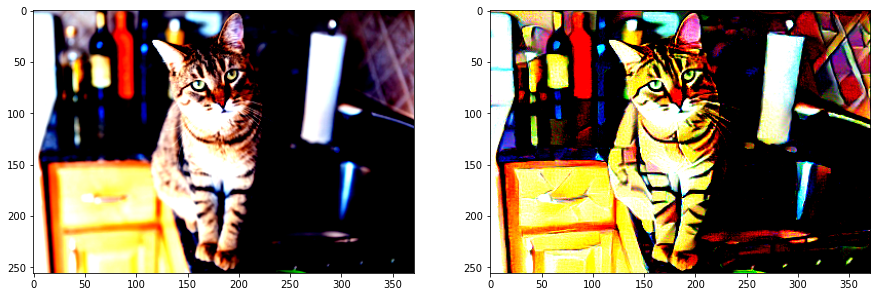

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.imshow(tensor_to_image(content_img))
ax2.imshow(tensor_to_image(target))